# Chapter 1. Main Concept of Graph Neural Network

이번 튜토리얼에서 우리는 CORA 데이터셋을 사용할 거에요. CORA 데이터셋은 인용 네트워크를 나타내는 데이터셋으로, 학술 논문들의 인용 관계를 그래프 형태로 나타냅니다. 각 Node는 논문을 나타내고, Edge는 논문 간의 인용 관계를 나타내죠.

* 노드(Node)란, Graph의 구성 요소이자 하나의 점으로 표현되는 개별 항목입니다. 추천 시스템에서는 유저와 아이템을 노드라고 할 수 있어요. Vertex라고 불리기도 합니다.
* 엣지(Edge)란, 두 노드 간의 연결 관계를 나타냅니다. 추천 시스템에서는 유저의 아이템 구매를 엣지로 연결할 수 있습니다. 유저 노드와 아이템 노드가 선으로 연결되는 것이죠.

CORA 데이터셋은 그래프 노드 분류를 위한 벤치마크 데이터셋으로 널리 사용됩니다. 우리는 이번 주에 배운 내용을 바탕으로, 다음 주에는 Node Classification 작업을 실제로 해 볼 거예요.
우선 일단은, torch_geometric.datasets 모듈에서 Planetoid 클래스를 사용해 CORA 그래프 데이터셋을 로드하고, 형태를 확인해 봅시다!

In [1]:
from torch_geometric.datasets import Planetoid
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

## CORA 데이터셋 로드

---

In [2]:
import os

if not os.path.exists('./tmp/Cora'):
    os.makedirs('./tmp/Cora')
dataset = Planetoid(root='./tmp/Cora', name='Cora')
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

data는 Data라는 클래스의 인스턴스로, PyTorch Geometric에서 제공하는 기본적인 데이터 구조입니다. Data 객체는 단일 그래프에 대한 정보를 담고 있으며, 여기에는 노드 피처, 엣지 연결, 노드 레이블 등의 정보가 포함됩니다. 튜플이라고 오해할 수도 있겠지만, 속지 마세요!
노드 피처, 엣지 연결, 노드 레이블 등의 정보는 Data 객체 내에 각각 별도의 속성으로 저장되어 있습니다. 각 속성은 그 자체로 PyTorch의 Tensor 객체에요.
예를 들어, Data 객체 data에 대해 다음과 같이 접근할 수 있답니다.

```
data.edge_index
```

그럼 이제 그래프의 재료가 될 CORA 데이터셋을 조금 더 자세히 살펴볼까요?

* x=[2708, 1433]: 각각 노드의 수 (2708개)와 각 노드에 연결된 특성의 수 (1433개)를 나타냅니다. 즉, 이 데이터셋에서는 총 2708개의 논문이 있으며, r각 논문은 1433개의 특성으로 표현됩니다.
* edge_index=[2, 10556]: 그래프의 엣지 정보를 저장한 리스트를 나타냅니다. 여기서 2는 두 노드를 연결하는 엣지를 나타내며, 10556은 총 엣지의 수를 나타냅니다. 그래프에서 엣지는 논문들 간의 인용 관계를 의미합니다.
* y=[2708]: 각 노드의 label 정보를 나타냅니다. 즉, 각 논문의 주제 분류 레이블이 담겨 있습니다.
* train_mask=[2708], val_mask=[2708], test_mask=[2708]: 각각 훈련, 검증, 테스트 세트를 구성하는 노드를 나타내는 boolean 마스크입니다.

## Graph & Degree

---

PyTorch Geometric의 Data 객체를 networkx 그래프로 변환해서, 그래프를 시각화하고, 더욱 직관적으로 분석해 봐요. 이 코드에서는 networkx의 `from_edgelist` 메서드를 사용하여 엣지 리스트를 받아 networkx 그래프 객체를 생성할 거랍니다.

여기서 주의할 점은, torch_geometric과 networkx은 원래 내부적으로 그래프 데이터를 다르게 표현하고 처리한다는 점이에요. 따라서 그래프를 변환하는 과정에서 *Node Feature 등의 정보가 손실될 수 있습니다. 하지만 이번 경우에는 그래프의 구조만 시각화하려는 것이므로, 이 점은 특별히 고려하지 않아도 괜찮아요!

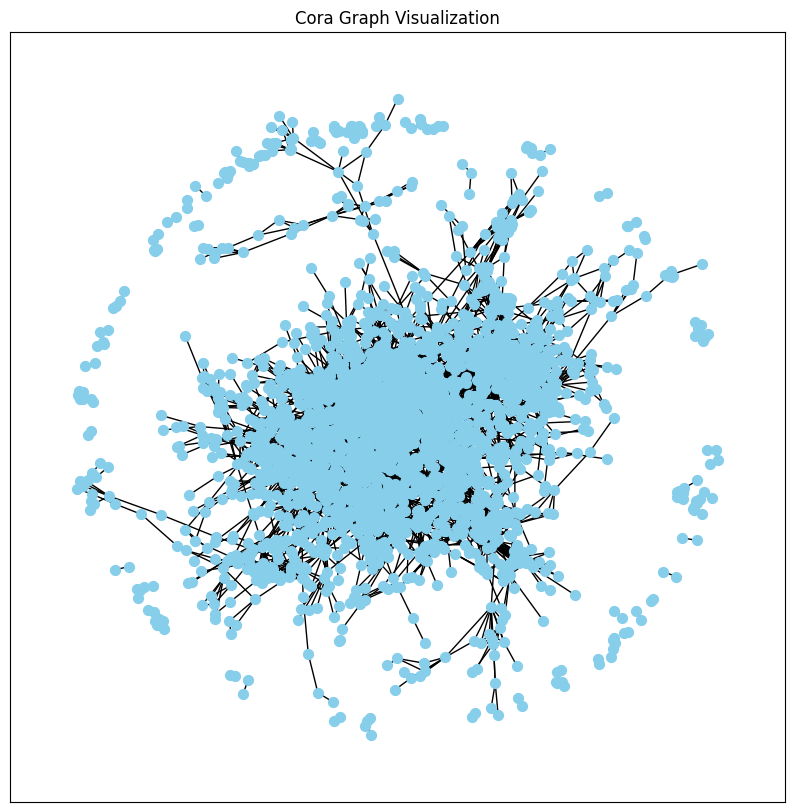

In [3]:
# torch_geometric의 데이터를 NetworkX 그래프로 변환
edge_index = data.edge_index
edges = edge_index.t().numpy()
graph_nx = nx.from_edgelist(edges, create_using=nx.Graph())

# 그래프 그리기
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph_nx, seed=42)  # Spring layout 사용
nx.draw_networkx(graph_nx, pos, with_labels=False, node_size=50, node_color="skyblue")
plt.title("Cora Graph Visualization")
plt.show()

### `pos`가 뭔가요?

`pos` 변수는 각 노드의 위치를 나타내는 딕셔너리입니다. 이는 `NetworkX`의 `nx.spring_layout` 함수를 통해 생성돼요. 그래프를 그릴 때, 각 노드의 위치는 pos 변수를 통해 제공됩니다.

### Spring Layout이 뭔가요?

`nx.spring_layout` 함수에서, 그래프의 각 엣지는 노드 사이에 강하게 연결된 용수철로 생각되며, 이는 노드를 서로 가까이 끌어당깁니다. 반면에, 그래프의 모든 노드는 서로 밀어내는 힘을 가지고 있어, 이들을 멀리 밀어냅니다. 이 두 힘의 균형을 통해 최종적인 그래프 레이아웃이 형성됩니다.

### 그래프를 어떻게 해석할 수 있을까요?

그래프의 중심에 노드들이 많이 모여 있으면, 이 노드들은 서로 많은 연결(=Edge, Link)을 가지고 있을 가능성이 높습니다. 이것은 노드가 중요한 역할을 하는 'Hub' Node일 수 있다는 뜻이에요. 허브 노드는 그래프에서 중요한 역할을 하는 노드를 가리키며, 통상적으로 많은 수의 다른 노드와 연결되어 있습니다.
반면에, 그래프의 바깥 원에서 발견되는 노드들은 일반적으로 적은 수의 연결만을 가지고 있을 가능성이 높습니다. 이러한 노드들은 Peripheral Node라고 불립니다. 이들은 그래프의 전체 구조에 비교적 적은 영향을 미치며, 종종 특정 'Hub' Node 또는 그룹에 집중적으로 연결되어 있습니다.

## Node Degree

---

눈치채셨나요? Node에 있어서 연결이란 개념이 꽤 중요하다는 사실을 방금의 그래프 해석에서 알아낼 수 있었어요!
이 연결은 정확한 단어로 Node Degree, 한국어로는 노드의 차수라고 합니다.
다시 말해 노드의 degree란 그 노드에 연결되어 있는 Edge의 개수입니다. 즉, 노드가 얼마나 많은 다른 노드와 연결되어 있는지를 수치적으로 나타낼 수 있는 지표입니다.

우리의 그래프를 가지고 Degree의 분포를 한번 확인해 보기로 해요.

Counter({2: 583, 3: 553, 1: 485, 4: 389, 5: 281, 6: 131, 7: 82, 8: 57, 10: 26, 9: 25, 12: 18, 11: 14, 17: 8, 16: 7, 14: 6, 15: 6, 19: 5, 13: 5, 23: 3, 18: 3, 21: 3, 30: 2, 32: 2, 65: 1, 74: 1, 44: 1, 40: 1, 33: 1, 168: 1, 31: 1, 29: 1, 34: 1, 36: 1, 42: 1, 78: 1, 22: 1, 26: 1})


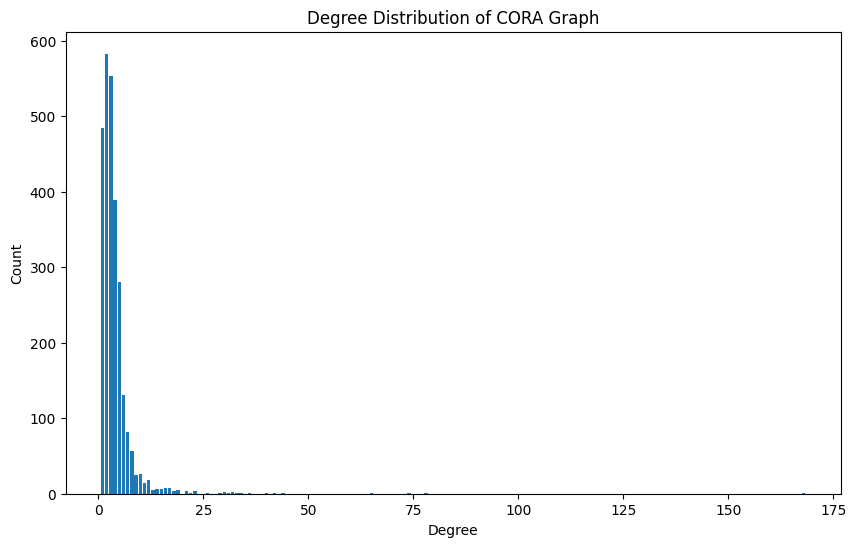

In [7]:
# node degree 계산
degrees = [degree for node, degree in nx.degree(graph_nx)]
degree_count = Counter(degrees)
print(degree_count)

# Degree 분포 출력
plt.figure(figsize=(10, 6))
plt.bar(degree_count.keys(), degree_count.values())
plt.title("Degree Distribution of CORA Graph")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

## Subgraph

---

한 걸음 더 가까이 가서 그래프를 구경하기 위해서는, 방금의 그래프를 조금 더 작은 단위로 나눠야 합니다. 바로 여기서 Subgraph라는 개념이 등장해요.

Subgraph는 원본 그래프에서 '선택한 특정 노드들과 그것에 연결된 엣지들로 구성된 그래프'를 의미합니다. 지금 우리의 상황처럼, 원본 그래프에서 일부만 고려하고 싶을 때 subgraph를 사용해요. 예를 들어, 네트워크에서 특정 사용자 그룹 간의 상호작용을 분석하려면 해당 특정 사용자들만을 포함하는 subgraph를 생성하면 됩니다.

우선, 우리는 쉽게 시작해 볼까요? 우선 Node 0를 중심으로 한 아주 간단한 Subgraph를 만들어 볼게요. 추가로 Node 0의 degree도 계산해 봅시다.

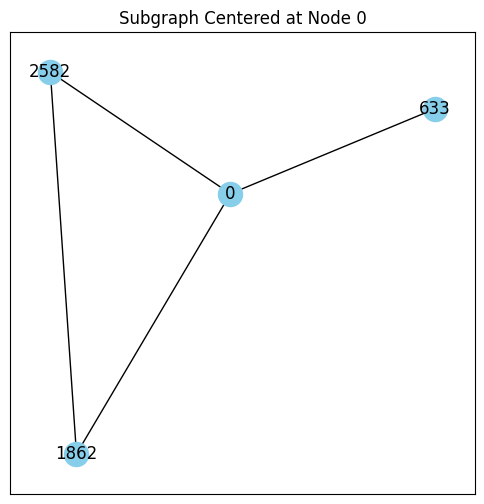

node degree(0) = 3


In [9]:
from torch_geometric.datasets import Planetoid
import networkx as nx
import matplotlib.pyplot as plt

# 특정 노드를 선택
selected_node = 0

# 선택한 노드와 직접적으로 연결된 노드들만으로 구성된 subgraph를 추출
neighbors = list(graph_nx.neighbors(selected_node))
neighbors.append(selected_node)
subgraph_nx = graph_nx.subgraph(neighbors)

# 그래프 그리기
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(subgraph_nx, seed=42)  # Spring layout 사용
nx.draw_networkx(subgraph_nx, pos, with_labels=True, node_color="skyblue")
plt.title("Subgraph Centered at Node {}".format(selected_node))
plt.show()

# node degree 출력
print(f"node degree({selected_node}) = {subgraph_nx.degree[selected_node]}")

이제 좀 Node와 Edge가 선명하게 보이네요! 가장 먼저, 우리의 중심 노드인 Node 0과 상호작용 관계에 있는 다른 노드가 총 3개라는 사실을 알 수 있습니다. 633, 1862, 2582네요. 앞서 설명한 대로 Edge는 노드 간 연결관계를 나타내므로, Node 1862와 2582 사이에도 상호작용이 있다는 점이 파악돼요.
Node 0의 Degree는 3입니다. 해당 노드에 연결되어 있는 Edge의 개수가 3개이니 당연하겠죠!

## Directrional Graph

---

방금까지 Node에 대한 이야기를 했으니, 이젠 Edge로의 여행 코스를 둘러볼까요? 앞서 엣지는 노드 간의 관계를 나타내고, 그래프의 구조를 정의하는 데 중요한 역할을 한다고 했죠. 여기서 주목할 점은 Edge에 방향성 개념이 있다는 것입니다.

CORA 데이터셋의 경우엔 각 노드는 논문 하나를 나타내고, 엣지는 한 논문이 다른 논문을 인용하는 관계를 나타냅니다. 다시 말해 Node 0 라는 논문이 Node 1862 논문을 인용한 경우, 엣지에는 0에서 출발해 1862를 가리키는 화살표, 즉 방향성이 생깁니다.

이론은 충분히 들은 것 같으니, 이제 직접 눈으로 확인해 볼까요? 서브그래프에 방향성을 부여하려면 원본 그래프에 있는 방향성 정보를 활용해 방향성 그래프(DiGraph)로 생성하거나 변환하는 과정이 필요합니다.

다만, CORA 데이터셋은 원래 방향성이 없습니다. 즉, 논문 A가 논문 B를 인용하더라도, 이것을 "노드 A가 노드 B로 향하는 엣지가 있다"고 해석하지 않습니다. 따라서 이 튜토리얼에서는 임의의 방향성을 추가하도록 코드를 작성해 볼게요. 추가로 Degree도 계산해 보고요.

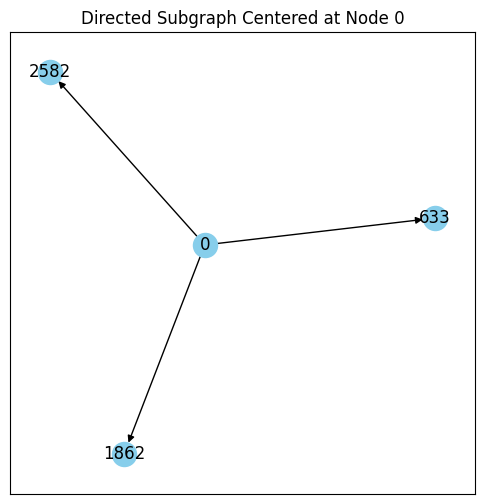

node out-degree(0) = 3
node in-degree(0) = 0


In [10]:
# 특정 노드를 선택
selected_node = 0

# 선택한 노드와 직접적으로 연결된 노드들만으로 구성된 서브그래프를 추출
neighbors = list(graph_nx.neighbors(selected_node))
neighbors.append(selected_node)
subgraph_nx = graph_nx.subgraph(neighbors)

# 서브그래프를 방향성 그래프로 변환
subgraph_nx_directed = nx.DiGraph()

# 선택된 노드에서 그 이웃 노드들로 향하는 방향성 추가
for neighbor in neighbors:
    if neighbor != selected_node:
        subgraph_nx_directed.add_edge(selected_node, neighbor)

# 그래프 그리기
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(subgraph_nx_directed, seed=42)  # Spring layout 사용
nx.draw_networkx(subgraph_nx_directed, pos, with_labels=True, node_color="skyblue", arrows=True)
plt.title("Directed Subgraph Centered at Node {}".format(selected_node))
plt.show()

# node degree 출력
print(f"node out-degree({selected_node}) = {subgraph_nx_directed.out_degree[selected_node]}")
print(f"node in-degree({selected_node}) = {subgraph_nx_directed.in_degree[selected_node]}")

## Undirected Graph

---

한편, 엣지에 방향성이 없는 그래프를 Undirected Graph(무방향 그래프)라고 합니다. 무방향 그래프에서는 어떤 노드에서 다른 노드로의 연결이 반대 방향으로도 성립합니다. Node 0와 노드 2582 사이에 엣지가 있으면, 0에서 2582로의 연결과 2582에서 0로의 연결 모두 가능하다는 의미랍니다.

## Weight

---

Edge에는 Direction뿐만 아니라 Weight도 추가될 수 있습니다. 엣지의 가중치는 노드 간의 거리를 반영해 그래프에서 최단 경로를 찾거나, 별점으로 상품의 선호도를 반영하거나, 채팅 횟수로 사람간의 친밀도를 측정하는 등 다양한 문제를 해결하는 데 중요한 역할을 합니다.

가중치가 없는 그래프를 Unweighted Graph라고 하며, 모든 엣지가 동일한 중요도를 가진다고 가정합니다. 반면에 가중치가 있는 그래프를 Weighted Graph라고 합니다.

하지만! CORA 데이터셋은 Unweighted Graph로, edge에 별도의 가중치가 존재하지 않습니다. 따라서 edge의 빈도수가 1로 동일하며, 이대로 시각화 한다면 모든 edge의 라벨이 1로 표시될 거에요.

그러니 이 튜토리얼에서는 numpy를 사용하여 edge 수만큼의 무작위 가중치를 생성하고, 이를 각 edge의 가중치로 설정합니다. 그 후에 이 가중치를 그래프에 표시하겠습니다. 아참, 아까 임의로 부여했던 방향성은 제거하고 말이죠.

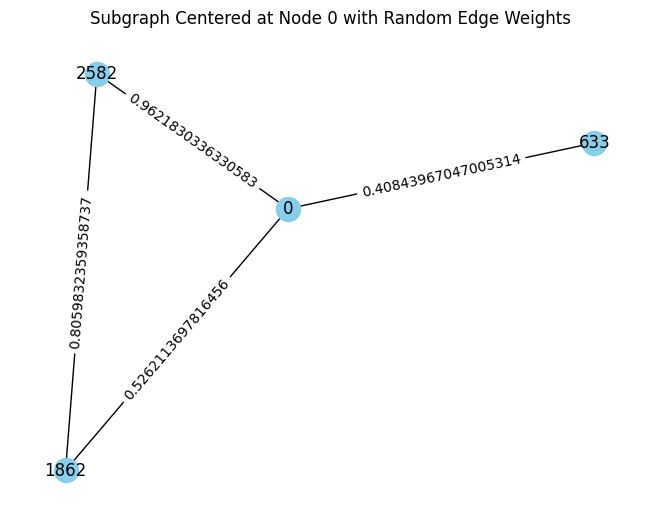

node degree(0) = 3


In [12]:
# CORA 데이터셋 로드
dataset = Planetoid(root='./tmp/Cora', name='Cora')
data = dataset[0]

# torch_geometric의 데이터를 NetworkX 그래프로 변환
edge_index = data.edge_index
edges = edge_index.t().numpy()
graph_nx = nx.from_edgelist(edges, create_using=nx.Graph())

# 특정 노드를 선택
selected_node = 0

# 선택한 노드와 직접적으로 연결된 노드들만으로 구성된 subgraph를 추출
neighbors = list(graph_nx.neighbors(selected_node))
neighbors.append(selected_node)
subgraph_nx = graph_nx.subgraph(neighbors)

# edge의 수만큼 무작위 가중치를 생성하고, 이를 각 edge의 가중치로 설정
weights = np.random.rand(subgraph_nx.number_of_edges())
for i, edge in enumerate(subgraph_nx.edges):
    subgraph_nx.edges[edge]['weight'] = weights[i]

# 그래프 그리기
pos = nx.spring_layout(subgraph_nx, seed=42)  # Spring layout 사용
nx.draw(subgraph_nx, pos, with_labels=True, node_color="skyblue")

# edge의 가중치를 그래프에 표시
edge_labels = nx.get_edge_attributes(subgraph_nx, 'weight')
nx.draw_networkx_edge_labels(subgraph_nx, pos, edge_labels=edge_labels)

plt.title("Subgraph Centered at Node {} with Random Edge Weights".format(selected_node))
plt.show()

# node degree 출력
print(f"node degree({selected_node}) = {subgraph_nx.degree[selected_node]}")

## Connected Graphs

---

연결 그래프(Connected Graph)는 그래프의 모든 노드가 Edge를 통해 서로 연결되어 있는 그래프를 의미합니다. 다시 말해, 그래프 내의 모든 노드가 직접적으로나 간접적으로 연결되어 있다면, 이 그래프는 Connected Graphs라고 할 수 있습니다.

> 노드 1개도 그래프라고 할 수 있어요?
> 
> 그렇습니다! 그래프 이론에서는 아무것도 연결되지 않은, 노드 하나로 이루어진 그래프도 그래프로 취급해요. 이러한 노드를 보통 '고립된 노드(Isolated Node)'라고 부릅니다.
> 
> 그러나 이런 노드 하나만을 가진 그래프는 연결 그래프의 정의를 만족하지 않습니다. 연결 그래프는 두 노드 간에 경로가 존재해야 하기 때문이에요. 고립된 노드로 이루어진 그래프에는 Edge가 존재하지 않기 때문에, 이 그래프는 Connected Graph라고는 할 수 없어요.

방금 배운 내용을 눈으로 확인해 볼까요? 이젠 개수를 3개로 늘려보죠.
노드 0, 1, 2를 중심으로 하는 서브그래프를 생성하고 각각의 연결성을 체크해 봐요.

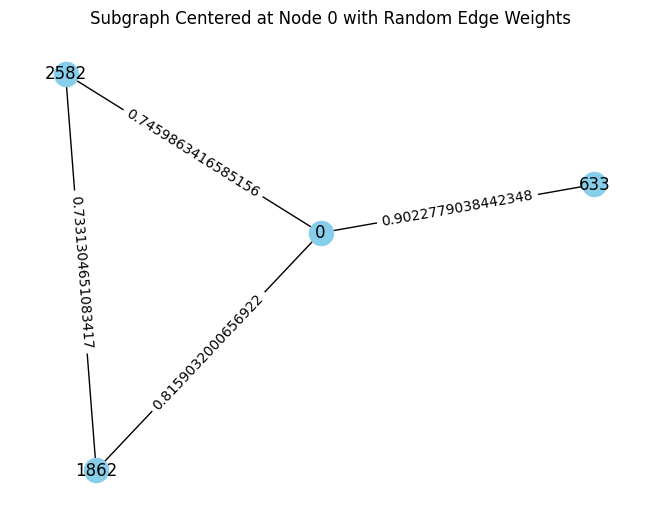

node degree(0) = 3
Is subgraph centered at node 0 connected? True


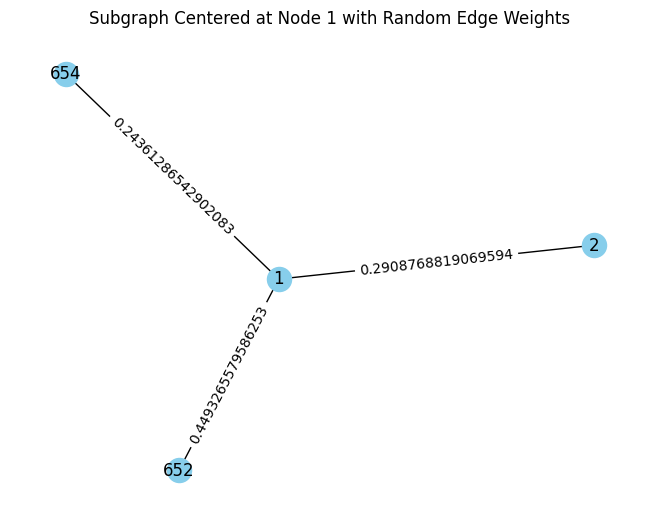

node degree(1) = 3
Is subgraph centered at node 1 connected? True


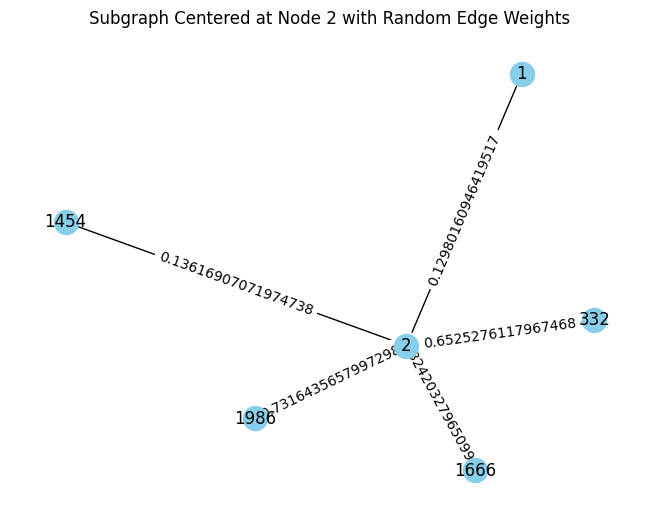

node degree(2) = 5
Is subgraph centered at node 2 connected? True


In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# 중심 노드를 선택 (여기서는 0, 1, 2를 선택)
center_nodes = [0, 1, 2]

for i, selected_node in enumerate(center_nodes):
    # 선택한 노드와 직접적으로 연결된 노드들만으로 구성된 subgraph를 추출
    neighbors = list(graph_nx.neighbors(selected_node))
    neighbors.append(selected_node)
    subgraph_nx = graph_nx.subgraph(neighbors)

    # edge의 수만큼 무작위 가중치를 생성하고, 이를 각 edge의 가중치로 설정
    weights = np.random.rand(subgraph_nx.number_of_edges())
    for i, edge in enumerate(subgraph_nx.edges):
        subgraph_nx.edges[edge]['weight'] = weights[i]

    # 그래프 그리기
    plt.figure(i)
    pos = nx.spring_layout(subgraph_nx, seed=42)  # Spring layout 사용
    nx.draw(subgraph_nx, pos, with_labels=True, node_color="skyblue")

    # edge의 가중치를 그래프에 표시
    edge_labels = nx.get_edge_attributes(subgraph_nx, 'weight')
    nx.draw_networkx_edge_labels(subgraph_nx, pos, edge_labels=edge_labels)

    plt.title("Subgraph Centered at Node {} with Random Edge Weights".format(selected_node))
    plt.show()

    # node degree 출력
    print(f"node degree({selected_node}) = {subgraph_nx.degree[selected_node]}")

    # 서브그래프의 연결성 확인
    print(f"Is subgraph centered at node {selected_node} connected? {nx.is_connected(subgraph_nx)}")


위 튜토리얼 코드는 Node 0, 1, 2를 각각 중심으로 하는 Subgraph를 생성하고, 랜덤하게 생성된 가중치를 설정한 후, 그래프를 그립니다. 그리고 각 서브그래프의 연결성과 각 중심 노드의 degree를 계산해요.

주의깊게 봐둬야 할 점은, `"Is subgraph centered at node connected?"` 부분입니다. 지금은 3개의 서브그래프에 대해 모두 True가 결과로 나왔죠. 하지만 저 서브그래프 3개를 모아놓으면 어떻게 될까요?

궁금하니까 큰 서브그래프 1개로 합쳐 봅시다!
공통 엣지를 고려해 그래프를 시각화 해보죠. Node 각각에 직접 연결되어 있는 이웃 노드들을 포함해 하나의 큰 서브그래프를 만들고, 그걸 그래프로 그려봐요.

## 큰 서브그래프 1개로 합쳐 봅시다!

---

node degree(0) = 3
node degree(1) = 3
node degree(2) = 5
Is subgraph connected? False


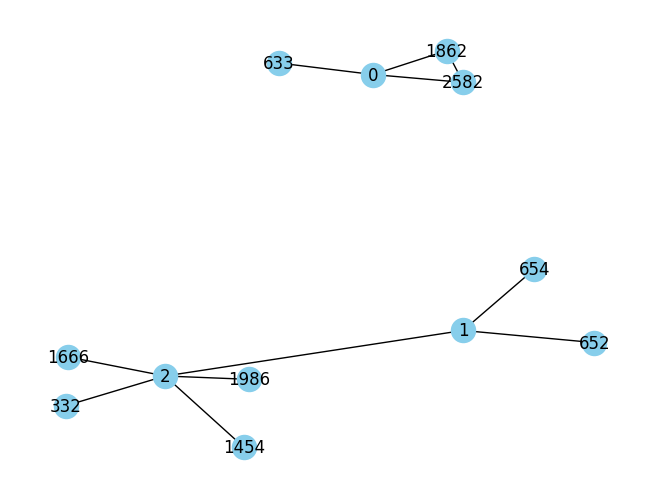

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# 중심 노드를 선택 (여기서는 1, 2를 선택)
center_nodes = [0, 1, 2]

# 모든 이웃 노드를 저장할 리스트 초기화
all_neighbors = []

# 중심 노드들의 모든 이웃 노드를 all_neighbors에 추가
for selected_node in center_nodes:
    neighbors = list(graph_nx.neighbors(selected_node))
    all_neighbors += neighbors

# 중심 노드들도 all_neighbors에 추가
all_neighbors += center_nodes

# all_neighbors에 포함된 모든 노드들만으로 구성된 subgraph를 추출
subgraph_nx = graph_nx.subgraph(all_neighbors)

# 그래프 그리기
pos = nx.spring_layout(subgraph_nx, seed=42)  # Spring layout 사용
nx.draw(subgraph_nx, pos, with_labels=True, node_color="skyblue")

# node degree 출력
for selected_node in center_nodes:
    print(f"node degree({selected_node}) = {subgraph_nx.degree[selected_node]}")

# 그래프의 연결성 확인
print(f"Is subgraph connected? {nx.is_connected(subgraph_nx)}")

plt.show()

이제는 Connected? 라는 물음의 답이 False로 나오네요. Node 1과 2는 Edge에 연결되어 있는 반면, Node 0는 낙동강 오리알🦆🥚처럼 동떨어져 있어요.

아하, 바로 이런 원리로 노드 뭉치가 생기는 거군요! 가장 처음 시각화했던 그래프가 기억나나요? 중심부에 노드 군집이 있었잖아요.

흠... 그렇다면 그 노드 뭉치 중에서는 어떤 노드가 가장 중심에 있을까요? 어떤 노드가 가장 중요할까요?
이 질문에 대답하기 위해선, Centrality를 측정해봐야 합니다.

## Centrality

---

Centrality, 즉 중심성 지표는 그래프 내에서 노드의 상대적인 중요도를 수치화합니다. 다시 말해, 우리는 이 수치를 통해 특정 노드가 그래프의 전체 구조에 얼마나 영향을 미치는지 알아낼 수 있어요. Centrality에는 여러 종류가 있으며, 각각 다른 측면의 Node Importance를 나타낸답니다. 각각에 대한 개념과, 계산 코드를 체크해 봅시다!

1. __Degree Centrality__: 이 방법은 그래프에서 노드의 중심성을 결정하는 가장 간단한 방법입니다. 한 노드의 중심성은 그 노드가 가지고 있는 직접적인 이웃 노드의 수에 비례합니다. 더 많은 이웃 노드를 가지고 있는 노드가 더 높은 중심성을 가집니다.
2. __Closeness Centrality__: 모든 다른 노드들과의 '가까움'을 측정합니다. 이 방법은 노드의 중심성을 해당 노드가 그래프 내의 다른 모든 노드에 얼마나 가까운지에 따라 결정합니다. 이를 측정하는 방법은 특정 노드로부터 그래프 내의 모든 다른 노드까지의 최단 경로의 평균 길이를 계산하는 것입니다. 근접 중심성이 높은 노드는 그래프 내의 다른 노드들에 대해 평균적으로 더 가까이 있습니다.
3. __Betweenness Centrality__: 노드가 네트워크의 다른 노드들 사이에서 얼마나 중요한 '다리' 역할을 하는지 측정합니다. 이 방법은 노드의 중심성을 그 노드가 그래프 내의 최단 경로들에서 얼마나 자주 등장하는지에 따라 결정합니다. 매개 중심성이 높은 노드는 다른 노드들 간의 상호작용에 있어 중요한 역할을 하는 '브리지' 또는 '중개자' 역할을 하고 있을 가능성이 높습니다.
4. __Eigenvector Centrality__: 노드의 중요성이 그 이웃의 중요성에 의해 결정되는 경우를 측정합니다. 이 방법은 노드의 중심성을 그 노드와 직접적으로 연결된 이웃 노드들의 중요성에 따라 결정합니다. 이 방법에서 중요한 노드는 중요한 이웃을 많이 가진 노드입니다. 이 방법은 Google의 PageRank 알고리즘에서 사용된 원리와 유사하답니다.

In [17]:
# Degree Centrality
degree_centrality = nx.degree_centrality(subgraph_nx)
print(f"Degree Centrality: {degree_centrality[0]}")  # 노드 0에 대해서만 계산

# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(subgraph_nx)
print(f"Betweenness Centrality: {betweenness_centrality[0]}")  # 노드 0에 대해서만 계산

# Eigenvector Centrality
# eigenvector_centrality = nx.eigenvector_centrality(subgraph_nx)
# print(f"Eigenvector Centrality: {eigenvector_centrality[0]}") # 노드 0에 대해서만 계산

# Closeness Centrality
closeness_centrality = nx.closeness_centrality(subgraph_nx)
print(f"Closeness Centrality: {closeness_centrality[0]}")  # 노드 0에 대해서만 계산

Degree Centrality: 0.2727272727272727
Betweenness Centrality: 0.03636363636363636
Closeness Centrality: 0.2727272727272727


## Density & Adjacency Matrix

---

그런데 우리가 지금 가방에 챙겨넣은 CORA 데이터셋은 꽤 복잡해 보였어요. 이 '복잡하다' 라는 말도 명확하게 수치화할 수 있을까요?

답은, "그렇다"입니다. 바로 Density(그래프의 밀도)를 통해서 말이죠. 이 개념은 그래프의 복잡성 판단, 데이터의 특성 이해, 성능 향상에 중요한 역할을 해요.

### 밀도(Density)

[연결되어 있는 엣지/그래프에 존재하는 모든 엣지] 의 비율을 나타냅니다. 이 값은 0과 1사이에 있답니다. 최대 밀도는 1이며, 이는 모든 노드가 서로 연결되어 있는 완전 그래프를 의미합니다. 최소 밀도는 0이며, 이는 엣지가 하나도 없는 그래프를 의미합니다.
실제 연결된 엣지의 수를 존재하는 모든 엣지의 수로 나눈 값으로 직접 계산해 볼 수도 있지만, 고맙게도 NetworkX 라이브러리는 그래프의 Density와 Adjacency Matrix를 계산하는 기능을 제공해요.

### Adjacency Matrix는

그래프의 노드들이 서로 어떻게 연결되어 있는지를 나타내는 행렬입니다. 이 행렬의 크기는 (노드 수) x (노드 수)입니다.
행렬의 각 행과 열은 그래프의 노드를 나타내고, 해당 위치의 행렬 원소 값은 두 노드 간의 엣지 여부 또는 가중치를 나타내요.

노드 0,1,2 서브그래프의 Density를 계산하고 Adjacency Matrix를 만들어 볼까요?

In [18]:
# 그래프의 Density 계산
density = nx.density(subgraph_nx)
print(f"Density: {density}")

# Adjacency Matrix 만들기
adj_matrix = nx.adjacency_matrix(subgraph_nx)

# Adjacency Matrix 출력하기
print("Adjacency Matrix:")
print(adj_matrix.todense())  # .todense()를 사용하여 sparse matrix를 dense matrix로 변환

Density: 0.16666666666666666
Adjacency Matrix:
[[0.         0.         0.         0.         0.         0.8159032
  0.         0.         0.         0.         0.74598634 0.9022779 ]
 [0.         0.         0.12980161 0.         0.         0.
  0.44932656 0.         0.24361287 0.         0.         0.        ]
 [0.         0.12980161 0.         0.82420328 0.73164357 0.
  0.         0.65252761 0.         0.13616907 0.         0.        ]
 [0.         0.         0.82420328 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.73164357 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.8159032  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.73313047 0.        ]
 [0.         0.44932656 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.65252761 0.      

코드 결과를 어떻게 해석할 수 있을까요?

* Density: 약 0.167의 결과값이 나왔네요. 가능한 모든 엣지 중 약 16.7%만이 실제로 연결되어 있음을 의미합니다.
* Adjacency Matrix(인접 행렬): 인접 행렬은 그래프의 노드 간 연결 관계를 행렬로 나타낸 것입니다. 행렬의 행과 열은 각각 그래프의 노드를 나타내며, 해당 위치의 값은 두 노드 간의 엣지의 가중치를 나타냅니다.

* 두 Node 사이에 Edge가 연결되어 있다면 대응하는 행렬의 cell 값 1로 채워지고, 노드 사이에 Edge 연결이 없다면 0으로 채워집니다.

어? 튜토리얼 코드가 출력한 건 0과 1이 아닌걸요?
그래프의 엣지에 가중치를 부여하면, 인접 행렬은 더 이상 이진(binary) 형태가 아니게 됩니다. 노드 간의 연결성을 표시하는 대신, 인접 행렬의 각 항목은 노드 간의 연결의 강도를 나타내는 가중치를 표시하게 됩니다.
우리는 앞선 튜토리얼 코드에서 Edge에 임의의 가중치를 부여했었죠? 그래서 인접 행렬의 값들은 0과 1 대신, 0과 가중치 값으로 채워졌습니다. 이렇게 가중치를 사용하면, 단순히 노드가 연결되어 있는지 아닌지보다 더 많은 정보를 포함하여, 노드간의 관계의 강도나 중요도 등을 나타낼 수 있답니다.